In [1]:
import os
import sys
import random
import gspread
import numpy as np
import pandas as pd
from glob import glob
from ast import literal_eval
import matplotlib.pyplot as plt
from xml.etree import ElementTree
from datetime import datetime
from dateutil.tz import tzlocal
from matplotlib.dates import (
    MONTHLY, YEARLY, DateFormatter, rrulewrapper, RRuleLocator, drange
)

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [5]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp, retEEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import find_nearest, XML2Dict
from allensdk.brain_observatory.ecephys.lfp_subsampling import subsampling

In [3]:
%matplotlib widget

What data exists in the experiment?

In [24]:
recfolder = r"P:\mouse709402\urethane_2024-02-16_11-15-43\experiment1\recording1"
exp = EEGexp(recfolder, preprocess=False)

Experiment type: electrical and sensory stimulation


In [25]:
exp.experiment_data

['probeB_sorted',
 'probeC_sorted',
 'probeD_sorted',
 'probeF_sorted',
 'recording1']

Make an array for grabbing frames

In [7]:
frames = np.linspace(0,199000,num=31)
print(frames)

[     0.           6633.33333333  13266.66666667  19900.
  26533.33333333  33166.66666667  39800.          46433.33333333
  53066.66666667  59700.          66333.33333333  72966.66666667
  79600.          86233.33333333  92866.66666667  99500.
 106133.33333333 112766.66666667 119400.         126033.33333333
 132666.66666667 139300.         145933.33333333 152566.66666667
 159200.         165833.33333333 172466.66666667 179100.
 185733.33333333 192366.66666667 199000.        ]


### Number of subjects and experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [6]:
print('Number of Zap&zip experiments: {:d}'.format(len(ZZ_metadata)))
print('Number of mice: {:d}'.format(len(np.unique(ZZ_metadata['mouse_name'].values))))

Number of Zap&zip experiments: 69
Number of mice: 45


In [7]:
print('Number of Templeton experiments: {:d}'.format(len(Temp_metadata)))
print('Number of mice: {:d}'.format(len(np.unique(Temp_metadata['mouse_name'].values))))

Number of Templeton experiments: 96
Number of mice: 39


In [8]:
96+69

165

In [9]:
45+39

84

### What are running_timestamps? Same as running_timestamps_master_clock?

In [3]:
rawrun = np.load(r"F:\psi_exp\mouse689242\aw_psi_2023-07-19_10-29-49\experiment1\recording1\raw_running_signal.npy")
run = np.load(r"F:\psi_exp\mouse689242\aw_psi_2023-07-19_10-29-49\experiment1\recording1\running_signal.npy")
runts = np.load(r"F:\psi_exp\mouse689242\aw_psi_2023-07-19_10-29-49\experiment1\recording1\running_timestamps.npy")
Mrunts = np.load(r"F:\psi_exp\mouse689242\aw_psi_2023-07-19_10-29-49\experiment1\recording1\running_timestamps_master_clock.npy")

In [5]:
print(len(run))
print(len(runts))
print(len(Mrunts))

784760
784760
784760


In [6]:
print(runts[0:10])

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


In [7]:
print(Mrunts[0:10])

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


<IPython.core.display.Javascript object>


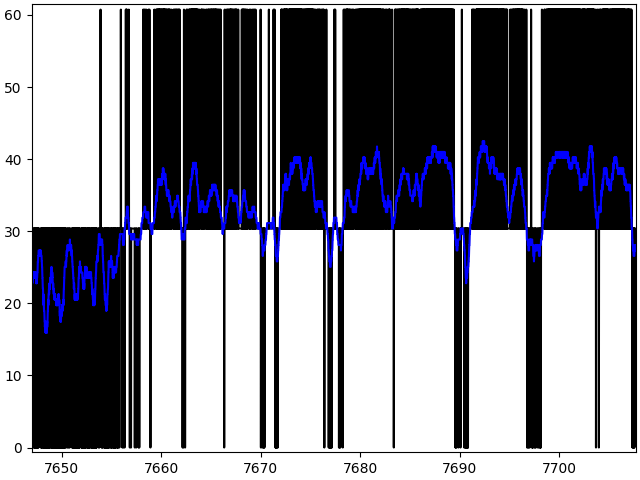

In [6]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(runts, rawrun, color='k')
ax.plot(runts, run, color='b')

### Test stim table generation

In [4]:
## Set durations ##
image_durations = [0.2, 0.5, 1.0]
n_presentation = 1 # number of presentation for each stimulus

## Set ISI ##
ISI_range = [2.0, 3.0]

## Image indices from Voytek lab ##
select_images = [
    4, 10, 15, 18, 22, 23, 25, 29, 30, 33, 35, 38, 39, 40, 42, 44, 50, 51, 52,
    53, 54, 55, 57, 59, 60, 62, 63, 65, 66, 69, 71, 72, 73, 76, 77, 79, 80, 82,
    84, 85, 86, 88, 91, 92, 93, 94, 95, 96, 97, 98, 100, 103, 107, 108, 111,
    113, 114, 115, 116, 117
]

In [8]:
[image_durations[0] * 3]

[0.6000000000000001]

In [11]:
image_list = []
duration_list = []
for imind in select_images:
    for dur in image_durations:
        image_list.append([imind] * n_presentation)
        duration_list.append([dur] * n_presentation)
image_list = np.concatenate(image_list)
duration_list = np.concatenate(duration_list)

In [13]:
duration_list

array([0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2,
       0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5,
       1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. ,
       0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2,
       0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5,
       1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. ,
       0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2,
       0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5,
       1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. ,
       0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2,
       0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5,
       1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. ,
       0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2,
       0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. , 0.2, 0.5, 1. ])

In [14]:
ISI_list = np.random.uniform(low=ISI_range[0], high=ISI_range[1], size=image_list.shape[0])
print(len(ISI_list))
print(ISI_list[:10])

180
[2.62747076 2.18561188 2.2751247  2.25978335 2.72536075 2.42394294
 2.71016544 2.34568577 2.40676618 2.46750393]


In [17]:
presentation_time = np.cumsum(np.concatenate(([ISI_list[0]], ISI_list[1:] + duration_list[:-1])))

In [25]:
print(len(presentation_time))

180


In [24]:
['natural_scene'] * 5

['natural_scene',
 'natural_scene',
 'natural_scene',
 'natural_scene',
 'natural_scene']

### Get today's date as datetime object

In [28]:
tday = datetime.now().astimezone()
print(tday)

2023-03-11 14:47:03.398210-08:00


### What type of recording?

In [5]:
exp1 = EEGexp(r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\experiment1\recording1', preprocess=False)
exp2 = EEGexp(r'F:\EEG_exp\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1', preprocess=False)
exp3 = EEGexp(r'B:\mouse657902\estim_2023-01-18_11-25-28\experiment1\recording1', preprocess=False)

Experiment type: electrical stimulation
Experiment type: electrical and sensory stimulation
This data does not contain an EEG recording.
Experiment type: electrical stimulation


In [8]:
exp3.experiment_data

['probeB_sorted', 'probeE_sorted']

In [11]:
testexp = exp3
if np.any([True for xd in testexp.experiment_data if 'recording' in xd]):
    print('Exp has EEG')
    if np.any([True for xd in testexp.experiment_data if 'probe' in xd]):
        print('Exp also has probes')
        tag = "EEG and Neuropixels"
    else:
        tag = "EEG"
elif np.any([True for xd in testexp.experiment_data if 'probe' in xd]):
    print('Exp only has Neuropixels')
    tag = "Neuropixels"

Exp only has Neuropixels


### Practice reading multisub csv and iterating through it? for NWB

In [4]:
multisub_file = r"E:\NWB_testing\all_subject_metadata.csv"
df = pd.read_csv(multisub_file).astype({'mouse': str})

In [5]:
df.head()

,mouse,sex,DOB,strain,exp_folder,reference,sweep_state,stim_region,stim_depth,bad_chs,invalid_sweeps,histology,data_loc
0,521885,M,2/4/2020,C57BL/6J,estim1_2020-07-09_14-23-49,"built-in surface electrode, left CB","awake,isoflurane",MOs,superficial,"6,7,8,10,11,12,13,14,15,16,17,18,21",NaN,no,C:\Users\lesliec\OneDrive - Allen Institute\da...
1,521886,M,2/4/2020,C57BL/6J,estim1_2020-07-16_13-37-02,"built-in surface electrode, left CB","awake,isoflurane,recovery",MOs,superficial,"10,11,12,13,14,15,16,17,18,19",NaN,no,C:\Users\lesliec\OneDrive - Allen Institute\da...
2,521887,F,2/4/2020,C57BL/6J,estim1_2020-07-30_11-25-05,"built-in surface electrode, left CB","awake,awake,isoflurane,isoflurane,isoflurane,r...",MOs,superficial,"4,7,9,11,12,13,14,15,18",NaN,slices,C:\Users\lesliec\OneDrive - Allen Institute\da...
3,543393,M,6/16/2020,C57BL/6J,estim1_2020-08-20_13-24-53,"stainless steel skull screw, frontal cortex","awake,awake,awake,isoflurane,isoflurane,isoflu...",MOs,superficial,"11,12,13,14,15,17",NaN,no,F:\EEG_exp\mouse543393\estim1_2020-08-20_13-24...
4,543394,M,6/16/2020,C57BL/6J,estim1_2020-08-27_14-32-00,"stainless steel skull screw, frontal cortex","awake,awake,awake,isoflurane,isoflurane,isoflu...",MOs,superficial,"11,12,13,14,15,17,18,19,20",NaN,no,F:\EEG_exp\mouse543394\estim1_2020-08-27_14-32...


In [6]:
for indi, row in df[:3].iterrows():
    print(row.mouse)

521885
521886
521887


In [7]:
type(row.mouse)

str

In [8]:
subject_info = row.to_dict()

In [9]:
subject_info

{'mouse': '521887',
 'sex': 'F',
 'DOB': '2/4/2020',
 'strain': 'C57BL/6J',
 'exp_folder': 'estim1_2020-07-30_11-25-05',
 'reference': 'built-in surface electrode, left CB',
 'sweep_state': 'awake,awake,isoflurane,isoflurane,isoflurane,recovery,recovery,recovery',
 'stim_region': 'MOs',
 'stim_depth': 'superficial',
 'bad_chs': '4,7,9,11,12,13,14,15,18',
 'invalid_sweeps': nan,
 'histology': 'slices',
 'data_loc': 'C:\\Users\\lesliec\\OneDrive - Allen Institute\\data\\mouse521887\\estim1_2020-07-30_11-25-05\\experiment1\\recordingfull'}

In [13]:
bug = datetime.strptime(subject_info['DOB'], '%m/%d/%Y').replace(tzinfo=tzlocal())

In [14]:
print(bug)

2020-02-04 00:00:00-08:00


### How to synchronize the messages on OpenEphys

In [4]:
recfolder = r"E:\TC_testing\mouse000000\message_test1_2023-03-10_19-15-59\experiment1\recording1"
eeg_samples_file = os.path.join(recfolder, r"continuous\Acquisition_Board-100.Rhythm Data\sample_numbers.npy")
eeg_ts_file = os.path.join(recfolder, r"continuous\Acquisition_Board-100.Rhythm Data\timestamps.npy")
msg_samples_file = os.path.join(recfolder, r"events\MessageCenter\sample_numbers.npy")
msg_ts_file = os.path.join(recfolder, r"events\MessageCenter\timestamps.npy")

In [5]:
eeg_samples = np.load(eeg_samples_file)
eeg_ts = np.load(eeg_ts_file)
msg_samples = np.load(msg_samples_file)
msg_ts = np.load(msg_ts_file)

In [12]:
print(eeg_ts[:5])
print(eeg_ts[-5:])

[10.752  10.7524 10.7528 10.7532 10.7536]
[59.39   59.3904 59.3908 59.3912 59.3916]


In [8]:
eeg_samples[:5]

array([26880, 26881, 26882, 26883, 26884], dtype=int64)

In [10]:
print(msg_ts)
print(msg_samples)

[14.5408 56.4224]
[ 36352 141056]


In [13]:
eeg_ts[36352]

25.2928

In [14]:
eeg_ts[eeg_samples == 36352]

array([14.5408])

In [15]:
recfolder = r"E:\TC_testing\mouse000000\message_test2_2023-03-10_19-17-24\experiment1\recording1"
eeg_samples_file = os.path.join(recfolder, r"continuous\Acquisition_Board-100.Rhythm Data\sample_numbers.npy")
eeg_ts_file = os.path.join(recfolder, r"continuous\Acquisition_Board-100.Rhythm Data\timestamps.npy")
msg_samples_file = os.path.join(recfolder, r"events\MessageCenter\sample_numbers.npy")
msg_ts_file = os.path.join(recfolder, r"events\MessageCenter\timestamps.npy")

In [16]:
eeg_samples = np.load(eeg_samples_file)
eeg_ts = np.load(eeg_ts_file)
msg_samples = np.load(msg_samples_file)
msg_ts = np.load(msg_ts_file)

In [17]:
print(eeg_ts[:5])
print(eeg_ts[-5:])

[20.48   20.4804 20.4808 20.4812 20.4816]
[56.2156 56.216  56.2164 56.2168 56.2172]


In [18]:
eeg_samples[:5]

array([51200, 51201, 51202, 51203, 51204], dtype=int64)

In [19]:
print(msg_ts)
print(msg_samples)

[41.6768 50.8928]
[104192 127232]


In [20]:
eeg_ts[104192]

IndexError: index 104192 is out of bounds for axis 0 with size 89344

In [21]:
eeg_ts[eeg_samples == 104192]

array([41.6768])

### Test datetime

In [4]:
DOB = datetime.fromisoformat('2020-02-04').replace(tzinfo=tzlocal())
print(DOB)

2020-02-04 00:00:00-08:00


## Get iso times

In [4]:
dfolder = r'F:\EEG_exp\mouse590480\estim_vis_2021-11-11_10-54-19\experiment1\recording1'
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [5]:
iso_induction, iso_maintenance = exp.load_iso_times()

In [6]:
print(iso_induction)

(3913.58, 4048.75)


In [7]:
print(iso_maintenance)

(4048.76, 8222.71)


### Pupil movie times

In [16]:
pupil_array = np.load(r"T:\zap-n-zip\EEG_exp\mouse590478\urethane_2021-10-29_11-51-38\experiment1\recording1\211029115125-0_pupil.npy")
pupil_array.shape

(2, 107958)

In [17]:
pupil_ts = pupil_array[0,:]
print(pupil_ts[0:10])

[8.02951 8.0741  8.07843 8.11189 8.14496 8.17815 8.21151 8.24484 8.27835
 8.31181]


In [18]:
diff_ts = np.diff(pupil_ts)
print(diff_ts[0:10])

[0.04459 0.00433 0.03346 0.03307 0.03319 0.03336 0.03333 0.03351 0.03346
 0.03859]


In [19]:
print(pupil_array[1,0:10])

[30.87101781 30.68534538 30.95124895 30.70122437 30.87944282 30.58950092
 30.90732584 30.82558063 30.75885781 30.80672792]


In [20]:
print(np.sum(diff_ts < 0.032))
# print(np.sum(diff_ts < 0.032))

10945


In [23]:
print((pupil_ts[-1] - pupil_ts[0]) * 30)

108093.5394


## Test EEG_exp class with newest OpenEphys version

In [4]:
data_folder = r'R:\GAT_recordings\mouse672785\EEGNPXspont_estim_2023-07-05_12-39-59\experiment1\recording1'
mouse = data_folder[data_folder.find('mouse')+5:data_folder.find('mouse')+11]
print(mouse)
data_folder = data_folder.rstrip('/')
print(data_folder)
experiment_folder = os.path.dirname(data_folder)
print(experiment_folder)

672785
R:\GAT_recordings\mouse672785\EEGNPXspont_estim_2023-07-05_12-39-59\experiment1\recording1
R:\GAT_recordings\mouse672785\EEGNPXspont_estim_2023-07-05_12-39-59\experiment1


In [5]:
expdir = os.path.dirname(experiment_folder)
print(expdir)

R:\GAT_recordings\mouse672785\EEGNPXspont_estim_2023-07-05_12-39-59


In [6]:
experiment_data = []
continuous_folder = sorted(glob(experiment_folder + '/**/continuous', recursive=True))[0]
print(continuous_folder)
continuous_files = sorted(glob(continuous_folder + '/**/*continuous.dat', recursive=True))
print(continuous_files)
cont_data_dir = os.path.dirname(continuous_files[0])
print(cont_data_dir)
experiment_data.append(os.path.basename(os.path.dirname(continuous_folder)))

R:\GAT_recordings\mouse672785\EEGNPXspont_estim_2023-07-05_12-39-59\experiment1\probeB_sorted\continuous
['R:\\GAT_recordings\\mouse672785\\EEGNPXspont_estim_2023-07-05_12-39-59\\experiment1\\probeB_sorted\\continuous\\Neuropix-PXI-100.0\\continuous.dat', 'R:\\GAT_recordings\\mouse672785\\EEGNPXspont_estim_2023-07-05_12-39-59\\experiment1\\probeB_sorted\\continuous\\Neuropix-PXI-100.1\\continuous.dat']
R:\GAT_recordings\mouse672785\EEGNPXspont_estim_2023-07-05_12-39-59\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.0


In [7]:
infofiles = sorted(glob(os.path.dirname(continuous_folder) + '/structure.oebin', recursive=True))
Info = literal_eval(open(infofiles[0]).read())

IndexError: list index out of range

In [29]:
infofiles

['F:\\GAT1_EEG_pilot\\mouse672789\\visual_2023-06-28_13-08-49\\experiment1\\recording1/structure.oebin']

In [21]:
Rhythm_info = next(
    (sub for sub in Info['continuous'] if sub['source_processor_name'] in ['Rhythm FPGA', 'Acquisition Board']), None)
if not Rhythm_info:
    print('not rhythm')

In [22]:
Rhythm_info = [
    sub for sub in Info['continuous'] if sub['source_processor_name'] in ['Rhythm FPGA', 'Acquisition Board'] \
    or sub['source_processor_name'] == 'Acquisition Board'
][0]
if not Rhythm_info:
    print('not rhythm')

In [23]:
Rhythm_info['sample_rate']

2500.0

In [24]:
for kk in experiment_data:
    print(kk)

recording1


### Downsampling 30 kHz EEG data and saving new continuous.dat file

In [4]:
dfolder = r'F:\EEG_exp\mouse575102\urethane_2021-06-04_11-44-50\experiment1\recording1'
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)
if exp.ephys_params['EEG']['sample_rate'] != 2500:
    print('EEG sample rate was too high, need to downsample.')

Experiment type: electrical stimulation
SomnoSuite log file not found.
EEG sample rate was too high, need to downsample.


In [5]:
data_memmap = np.memmap(exp.ephys_params['EEG']['continuous'], dtype='int16', mode='r')
eegdata = data_memmap.reshape((int(data_memmap.size/exp.ephys_params['EEG']['num_chs']), exp.ephys_params['EEG']['num_chs']))
print(eegdata.shape)

(80908800, 40)


In [6]:
full_timestamps = np.load(exp.ephys_params['EEG']['timestamps'])
print(full_timestamps.shape)

(80908800,)


In [7]:
channels = np.arange(0, eegdata.shape[1], dtype='int')
print(channels.shape)
downsamplefactor = int(exp.ephys_params['EEG']['sample_rate'] / 2500)
print(downsamplefactor)

(40,)
12


In [8]:
ssdata = subsampling.subsample_lfp(eegdata, channels, subsampling_factor=downsamplefactor)
ss_timestamps = subsampling.subsample_timestamps(full_timestamps, subsampling_factor=downsamplefactor)
print(ssdata.shape)
print(ss_timestamps.shape)

(6742400, 40)
(6742400,)


In [9]:
ssdata_path = os.path.join(os.path.dirname(exp.ephys_params['EEG']['continuous']), 'sscontinuous.dat')
ssts_path = os.path.join(os.path.dirname(exp.ephys_params['EEG']['timestamps']), 'sstimestamps.npy')

In [10]:
# save subsampled master timestamps as python array #
np.save(ssts_path, ss_timestamps, allow_pickle=False)

In [11]:
# save flattened subsampled eeg data as .dat file #
file = open(ssdata_path, 'wb')
file.write(ssdata.flatten())
file.close()

### Plotting data vs date

In [41]:
dates = [
    '2/12/2020', '2/19/2020', '8/20/2020', '9/3/2020', '9/29/2020', '10/13/2020', '12/8/2020', '1/19/2021',
    '2/2/2021', '2/17/2021', '2/18/2021', '3/2/2021', '3/16/2021', '3/30/2021', '4/13/2021', '4/27/2021', '5/11/2021'
]
x_values = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in dates]
unchecked = ['5/25/2021', '6/1/2021']
undates = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in unchecked]
uny = [1.5, 1.5]

In [22]:
dates2 = [
    '11/4/2020', '12/16/2020', '2/10/2021', '3/9/2021', '4/7/2021', '5/5/2021'
]
x2 = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in dates2]

In [15]:
y_values = [0,0,1,0,1,0,1,2,1,0,1,1,1,1,0,1,1]
y2 = [3,2,3,2,3,3]

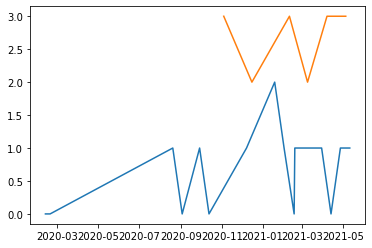

In [16]:
fig, ax = plt.subplots()
ax.plot(x_values, y_values)
ax.plot(x2, y2)

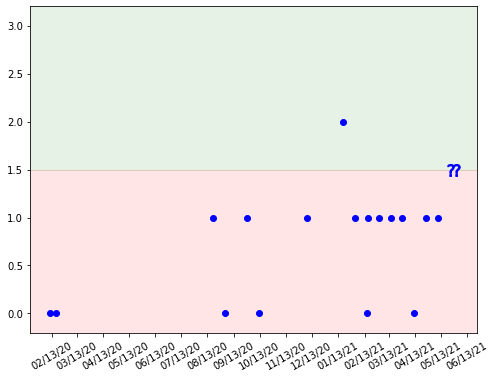

In [45]:
rule = rrulewrapper(MONTHLY)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')
date1 = datetime.date(2020, 2, 1)
date2 = datetime.date(2021, 7, 1)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot_date(x_values, y_values, color='b')
plt.plot_date(undates, uny, color='b', marker='$?$', markersize=12)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.set_ylim([-0.2, 3.2])
ax.axhspan(-0.2, 1.5, color='r', alpha=0.1)
ax.axhspan(1.5, 3.2, color='g', alpha=0.1)

plt.show()

## Importing excel sheet

In [19]:
vismetadata = pd.read_excel(
    r'C:\Users\lesliec\OneDrive - Allen Institute\EEG_exp info.xlsx',
    sheet_name='Visual Experiments',
    dtype='str'
)
vismetadata = vismetadata.astype({'Bad chs': str})

In [20]:
vismetadata.head()

,Mouse,Experiment Date,Folder,Visual stim,Has iso?,V1 probe?,Awake sweeps,Iso sweeps,Bad chs
0,521885,2020-07-08 00:00:00,audio_vis1_2020-07-08_12-37-58,black/white fullscreen,Y,N,0,1,6
1,521886,2020-07-15 00:00:00,audio_vis1_2020-07-15_13-28-29,black/white fullscreen,Y,N,0,1,nan
2,543394,2020-08-26 00:00:00,audio_vis1_2020-08-26_11-47-55,white fullscreen,Y,N,"0, 1, 2","3, 4, 5","18, 19, 20"
3,543395,2020-09-02 00:00:00,audio_vis1_2020-09-02_13-25-18,white fullscreen,Y,N,"0, 1, 2","3, 4, 5","0, 1"
4,543396,2020-09-18 00:00:00,estim_vis1_2020-09-18_12-04-46,white fullscreen,Y,Y,0,1,"4, 5, 7, 8, 10, 11, 12, 13, 14"


In [21]:
type(vismetadata.loc[1, 'Bad chs'])

str

In [22]:
type(vismetadata.loc[1, 'Awake sweeps'])

str

### importing the Zap_Zip-log_exp excel sheet as a DataFrame, per Saurabh's instructions

In [4]:
_gc = gspread.service_account() # need a key file to access the account (step 2)
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [5]:
zzmetadata.head()

,mouse_name,exp_name,brain states,stimulation,visual_stim,audio_stim,ISI (sec),stimulus duration (msec),Current (uA),Cortical Area stimulation,N trials per stimulus,EEG bad_channels,Npx,Units Sorted (X),Brain slices (X),Pupil tracking pre-processing,Brain areas assignment,"CCF coordinates stim electrode (surface,tip)","CCF area stim electrode (surface,tip)",Notes
1,mouse496220,audio_vis1_2020-06-10_14-54-43,awake/ISO,sensory,black/white,whitenoise/10000,5,250,,,60,None,None,None,None,None,None,None,None,None
2,mouse496220,audio_vis2_2020-06-11_11-42-47,awake/ISO,sensory,black/white,whitenoise/10000,5,250,,,60,29,None,None,None,None,None,None,None,None
3,mouse496220,audio_vis3_2020-06-16_10-35-57,run/resting,sensory,black,whitenoise,5,250,,,20,None,None,None,None,None,None,None,None,None
4,mouse496220,audio_vis4_2020-06-18_13-49-17,run/resting,sensory,black/white,whitenoise/10000,5,250,,,60,None,None,None,None,None,None,None,None,None
5,mouse521885,audio_vis1_2020-07-08_12-37-58,awake/ISO,sensory,black/white,whitenoise/10000,[3.5 4.5],250,,,50,6,None,None,None,None,None,None,None,None


In [9]:
testexp = EEGexp(r"C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521887\estim1_2020-07-30_11-25-05\experiment1\recordingfull", preprocess = False)

Experiment type: electrical stimulation
SomnoSuite log file not found.


In [10]:
print(os.path.basename(os.path.dirname(testexp.experiment_folder)))

estim1_2020-07-30_11-25-05


In [11]:
selmouse = zzmetadata[zzmetadata['mouse_name'].str.contains(testexp.mouse)]
selmouse.head()

,mouse_name,exp_name,brain states,stimulation,visual_stim,audio_stim,ISI (sec),stimulus duration (msec),Current (uA),Cortical Area stimulation,N trials per stimulus,EEG bad_channels,Npx,Units Sorted (X),Brain slices (X),Pupil tracking pre-processing,Brain areas assignment,"CCF coordinates stim electrode (surface,tip)","CCF area stim electrode (surface,tip)",Notes
9,mouse521887,audio1_2020-07-29_09-13-05,awake/awake/awake/ISO/ISO/ISO_low/recovery/rec...,sensory,N/A,whitenoise/10000,2.5,250,,,100,"7,18",None,None,None,None,None,None,None,None
10,mouse521887,estim1_2020-07-30_11-25-05,awake/awake,electrical,N/A,N/A,[3.5 4.5],0.2,20,M2,100,"4,7,9,11,12,13,14,15,18",None,None,None,None,None,None,None,None
11,mouse521887,estim2_2020-07-30_11-42-29,ISO/ISO/ISO/recovery/recovery/recovery,electrical,N/A,N/A,[3.5 4.5],0.2,20,M2,100,"4,7,9,11,12,13,14,15,18",,,X,,,,,this one is a continuation of the previous rec...


In [12]:
selexp = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(testexp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(testexp.experiment_folder))))
)].squeeze()
print(selexp['EEG bad_channels'])
print(type(selexp['EEG bad_channels']))

4,7,9,11,12,13,14,15,18
<class 'str'>


In [13]:
currentstr = selexp['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(int(char))
print(currentstr)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
    print(PCI_stim_amp)
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
    print(PCI_stim_amp)
else:
    print('No stim current listed in Zap_Zip-log_exp')

20
20


In [14]:
tstr = selexp['EEG bad_channels'].replace(' ','')
num_list = []
for char in tstr.split(','):
    if char.isdecimal():
        num_list.append(int(char))
print(tstr)
print(num_list)

6,7,8,10,11,12,13,14,15,16,17,18,21
[6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21]


In [40]:
test_strings = ['', '7', '3,6,7', ' ', '7, 10,22,3']
for tstr in test_strings:
    tstr = tstr.replace(' ','')
    num_list = []
    for char in tstr.split(','):
        if char.isdecimal():
            num_list.append(int(char))
    print(tstr)
    print(num_list)


[]
7
[7]
3,6,7
[3, 6, 7]

[]
7,10,22,3
[7, 10, 22, 3]


In [41]:
test_amps = ['', '80', '20/40/80', '30']
for tstr in test_amps:
#     tstr = tstr.replace(' ','')
    num_list = []
    for char in tstr.split('/'):
        if char.isdecimal():
            num_list.append(int(char))
    print(tstr)
    print(num_list)


[]
80
[80]
20/40/80
[20, 40, 80]
30
[30]


## Why don't my cluster IDs match?

In [4]:
exp = EEGexp(
    r"B:\mouse569065\pilot1_screwref_2021-05-21_13-12-08\experiment1\recording1",
    preprocess = False,
)
print(exp.experiment_data)

This data does not contain an EEG recording.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
['probeB_sorted', 'probeF_sorted']


In [5]:
probe_name = 'probeB'
cluster_group = pd.read_csv(exp.ephys_params[probe_name]['cluster_group'], sep='\t')
cluster_metrics = pd.read_csv(exp.ephys_params[probe_name]['cluster_metrics'])
spike_clusters = np.load(exp.ephys_params[probe_name]['spike_clusters'])

In [13]:
cluster_metrics['cluster_id']

0        0
1        1
2        2
3        3
4        4
      ... 
612    619
613    620
614    621
615    622
616    623
Name: cluster_id, Length: 617, dtype: int64

In [12]:
cluster_group.head()

,cluster_id,group
0,0,good
1,1,good
2,2,good
3,3,good
4,4,good


In [6]:
select_units, peak_chs, unit_metrics = exp.get_probe_units(probe_name)

In [6]:
print(len(np.unique(spike_clusters)))

617


In [7]:
print(len(cluster_group['cluster_id'].values.astype('int')))

617


In [8]:
print(len(cluster_metrics['cluster_id'].values.astype('int')))

617


In [9]:
print(np.unique(spike_clusters))
print(cluster_group['cluster_id'].values.astype('int'))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 25

### Playing with GridSpec

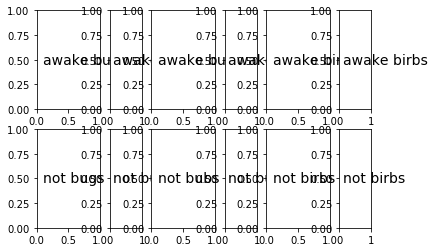

In [28]:
plot_chs = ['bugs', 'bubs', 'birbs']
plot_states = ['awake', 'not']
widths = [2, 1]
heights = [1]
gs_kw = dict(width_ratios=widths*len(plot_chs), height_ratios=heights*len(plot_states))
fig, axes = plt.subplots(ncols=len(widths)*len(plot_chs), nrows=len(heights)*len(plot_states), gridspec_kw=gs_kw)

for r, (row, statei) in enumerate(zip(axes, plot_states)):
    for c, ax in enumerate(row):
        label = statei + ' ' + plot_chs[int(np.floor(c/len(widths)))]
        ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

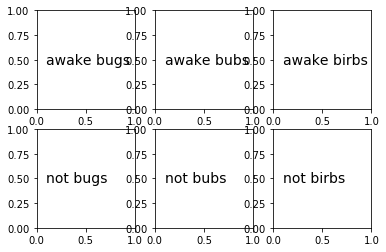

In [29]:
plot_chs = ['bugs', 'bubs', 'birbs']
plot_states = ['awake', 'not']

fig = plt.figure()
gs = fig.add_gridspec(ncols=len(plot_chs), nrows=len(plot_states))

for row, statei in enumerate(plot_states):
    for col, chi in enumerate(plot_chs):
        ax = fig.add_subplot(gs[row, col])
        label = statei + ' ' + chi
        ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

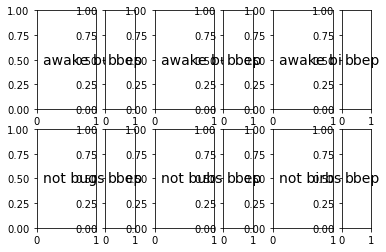

In [30]:
## THIS ONE WORKS ##
plot_chs = ['bugs', 'bubs', 'birbs']
plot_states = ['awake', 'not']

fig = plt.figure()
gs = fig.add_gridspec(ncols=len(plot_chs), nrows=len(plot_states))

for row, statei in enumerate(plot_states):
    for col, chi in enumerate(plot_chs):
        gsi = gs[row, col].subgridspec(ncols=2, nrows=1, width_ratios=[2,1])
        label = statei + ' ' + chi
        ax0 = fig.add_subplot(gsi[0])
        ax0.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')
        ax1 = fig.add_subplot(gsi[1])
        ax1.annotate('bbep', (0.1, 0.5), xycoords='axes fraction', va='center')

In [18]:
blubs = np.array([0,1,2,3,4,5])
print(np.floor(blubs/2).astype(int))

[0 0 1 1 2 2]


In [21]:
int(np.floor(3/2))

1

### What shape is the templates.npy array?

In [4]:
spike_clusters = np.load(r"F:\EEG_exp\mouse547868\estim_ramp_depth_2020-12-03_10-39-59\experiment1\probeA_sorted\continuous\Neuropix-PXI-100.0\spike_clusters.npy")
cluster_ids = np.unique(spike_clusters)
print(len(cluster_ids))

764


In [5]:
print(cluster_ids)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 119 120 121 122 123 124 125 126 127 128 129
 130 131 133 134 135 136 137 138 139 140 141 142 143 144 145 146 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 25

In [6]:
templates = np.load(r"F:\EEG_exp\mouse547868\estim_ramp_depth_2020-12-03_10-39-59\experiment1\probeA_sorted\continuous\Neuropix-PXI-100.0\templates.npy")
print(templates.shape)

(774, 82, 277)


In [9]:
os.path.dirname(r"F:\EEG_exp\mouse547868\estim_ramp_depth_2020-12-03_10-39-59\experiment1\probeA_sorted\continuous\Neuropix-PXI-100.0\templates.npy")

'F:\\EEG_exp\\mouse547868\\estim_ramp_depth_2020-12-03_10-39-59\\experiment1\\probeA_sorted\\continuous\\Neuropix-PXI-100.0'

### Checking timestamps

In [7]:
# rec3a1 = EEGexp(r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1', preprocess=False)
# recpxi1 = EEGexp(r'F:\EEG_exp\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1', preprocess=False)
recpxi2 = EEGexp(r'E:\EEG_NPX_testing\mouse546656\rec3_2020-11-13_12-08-14\experiment1\recording1', preprocess=True)

This data does not contain an EEG recording.
No *stim* files were found.
Experiment type: spontaneous
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Aligning timestamps for all datasets...
probeB AP and LFP
Creating E:\EEG_NPX_testing\mouse546656\rec3_2020-11-13_12-08-14\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.0\timestamps_master_clock.npy
Creating E:\EEG_NPX_testing\mouse546656\rec3_2020-11-13_12-08-14\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.1\timestamps_master_clock.npy
Creating E:\EEG_NPX_testing\mouse546656\rec3_2020-11-13_12-08-14\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.0\spike_times_master_clock.npy
probeC AP and LFP
Creating E:\EEG_NPX_testing\mouse546656\rec3_2020-11-13_12-08-14\experiment1\probeC_sorted\continuous\Neuropix-PXI-100.0\timestamps_master_clock.npy
Creating E:\EEG_NPX_testing\mouse546656\rec3_2020-11-13_12-08-14\experiment1\probeC_sorted\continuous\Neuropix-PXI-100.1\timestamps_maste

In [9]:
check_probe = 'probeC'

# print(rec3a1.mouse)
# apts1 = np.load(rec3a1.ephys_params[check_probe]['ap_timestamps'])
# lfpts1 = np.load(rec3a1.ephys_params[check_probe]['lfp_timestamps'])
# print('AP timestamp: {:.5f}'.format(apts1[0]))
# print('LFP timestamp: {:.5f}'.format(lfpts1[0]))

# print(recpxi1.mouse)
# apts2 = np.load(recpxi1.ephys_params[check_probe]['ap_timestamps'])
# lfpts2 = np.load(recpxi1.ephys_params[check_probe]['lfp_timestamps'])
# print('AP timestamp: {:.5f}'.format(apts2[0]))
# print('LFP timestamp: {:.5f}'.format(lfpts2[0]))

print(recpxi2.mouse)
apts3 = np.load(recpxi2.ephys_params[check_probe]['ap_timestamps'])
lfpts3 = np.load(recpxi2.ephys_params[check_probe]['lfp_timestamps'])
print('AP timestamp: {:.5f}'.format(apts3[0]))
print('LFP timestamp: {:.5f}'.format(lfpts3[0]))

546656
AP timestamp: 2.33587
LFP timestamp: 2.33704


What about spiketimes??

In [10]:
times3a = np.load(r"F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\probeB_sorted\continuous\Neuropix-3a-100.0\timestamps.npy")
times3b = np.load(r"E:\EEG_NPX_testing\mouse546656\rec1_2020-11-13_11-07-00\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.0\timestamps.npy")

spiketimes3a = np.load(r"F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\probeB_sorted\continuous\Neuropix-3a-100.0\spike_times.npy")
spiketimes3b = np.load(r"E:\EEG_NPX_testing\mouse546656\rec1_2020-11-13_11-07-00\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.0\spike_times.npy")

In [11]:
print(times3a[0:10])
print(times3b[0:10])

print(spiketimes3a[0:10])
print(spiketimes3b[0:10])

[0 1 2 3 4 5 6 7 8 9]
[22055797 22055798 22055799 22055800 22055801 22055802 22055803 22055804
 22055805 22055806]
[ 85 114 123 173 195 195 209 214 227 240]
[153 183 252 255 266 280 366 380 406 450]


In [ ]:
print()

### What if there is no EEG data?

In [6]:
data_folder = r'F:\opto_pilot\mouse621102\opto_cortical_pilot_2022-06-03_12-09-01\experiment1\recording1'
exp = EEGexp(data_folder, preprocess=False)
print(exp.experiment_data)
if 'EEG' in exp.ephys_params.keys():
    print('yes to eeg data')

Experiment type: electrical stimulation
['probeB_sorted', 'probeC_sorted', 'probeF_sorted', 'recording1']
yes to eeg data


In [5]:
data_folder2 = r'F:\EEG_exp\mouse543396\no_eeg_test\experiment1\recording1'
noeeg_exp = EEGexp(data_folder2, preprocess=True)
print(noeeg_exp.experiment_data)
if 'EEG' in noeeg_exp.ephys_params.keys():
    print('yes to eeg data')
else:
    print('no eeg data')

This data does not contain an EEG recording.
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Aligning timestamps for all datasets...
probeB AP and LFP
Using previous timestamp alignment. Delete file at F:\EEG_exp\mouse543396\no_eeg_test\experiment1\probeB_sorted\continuous\Neuropix-3a-100.0\timestamps_master_clock.npy to realign timestamps.
Using previous spiketime alignment. Delete file at F:\EEG_exp\mouse543396\no_eeg_test\experiment1\probeB_sorted\continuous\Neuropix-3a-100.0\spike_times_master_clock.npy to remake spiketimes_master_clock.
probeC AP and LFP
Using previous timestamp alignment. Delete file at F:\EEG_exp\mouse543396\no_eeg_test\experiment1\probeC_sorted\continuous\Neuropix-3a-100.0\timestamps_master_clock.npy to realign timestamps.
Using previous spiketime alignment. Delete file at F:\EEG_exp\mouse543396\no_eeg_test\experiment1\probeC_sorted\continuous\Neuropix-3a-100.0\spike_times_master_clock.npy to remake spiketimes_master_clock.
['

In [6]:
os.listdir(exp.experiment_folder)

['probeB_sorted', 'probeC_sorted', 'recording1']

In [7]:
continuous_dirs = sorted(glob(exp.experiment_folder + '/**/continuous', recursive=True))
print(continuous_dirs)

['F:\\opto_pilot\\mouse621102\\opto_cortical_pilot_2022-06-03_12-09-01\\experiment1\\probeB_sorted\\continuous', 'F:\\opto_pilot\\mouse621102\\opto_cortical_pilot_2022-06-03_12-09-01\\experiment1\\probeC_sorted\\continuous', 'F:\\opto_pilot\\mouse621102\\opto_cortical_pilot_2022-06-03_12-09-01\\experiment1\\probeF_sorted\\continuous', 'F:\\opto_pilot\\mouse621102\\opto_cortical_pilot_2022-06-03_12-09-01\\experiment1\\recording1\\continuous']


In [8]:
for contdir in continuous_dirs:
    print(sorted(glob(contdir + '/**/*continuous.dat', recursive=True)))

['F:\\opto_pilot\\mouse621102\\opto_cortical_pilot_2022-06-03_12-09-01\\experiment1\\probeB_sorted\\continuous\\Neuropix-PXI-100.1\\continuous.dat']
['F:\\opto_pilot\\mouse621102\\opto_cortical_pilot_2022-06-03_12-09-01\\experiment1\\probeC_sorted\\continuous\\Neuropix-PXI-100.1\\continuous.dat']
['F:\\opto_pilot\\mouse621102\\opto_cortical_pilot_2022-06-03_12-09-01\\experiment1\\probeF_sorted\\continuous\\Neuropix-PXI-100.1\\continuous.dat']
['F:\\opto_pilot\\mouse621102\\opto_cortical_pilot_2022-06-03_12-09-01\\experiment1\\recording1\\continuous\\Rhythm_FPGA-102.0\\continuous.dat']


What if there is no EEG continuous file?

In [13]:
cont_dirs_noeeg = sorted(glob(r'F:\EEG_exp\mouse543396\no_eeg_test\experiment1' + '/**/*continuous', recursive=True))
print(cont_dirs_noeeg)

['F:\\EEG_exp\\mouse543396\\no_eeg_test\\experiment1\\probeB_sorted\\continuous', 'F:\\EEG_exp\\mouse543396\\no_eeg_test\\experiment1\\probeC_sorted\\continuous', 'F:\\EEG_exp\\mouse543396\\no_eeg_test\\experiment1\\recording1\\continuous']


In [25]:
for contdir in cont_dirs_noeeg:
    print(os.path.basename(os.path.dirname(contdir)))
    if not sorted(glob(contdir + '/**/*continuous.dat', recursive=True)):
        if 'recording' in contdir:
            print('no EEG file')
    else:
        print('has cont file/s')
    if 'probe' in contdir:
        print(contdir[contdir.find('probe'):contdir.find('probe')+6])

probeB_sorted
has cont file/s
probeB
probeC_sorted
has cont file/s
probeC
recording1
no EEG file


### What if the AP timestamps get deleted?

In [4]:
data_folder = r'F:\EEG_exp\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1'
exp = EEGexp(data_folder, preprocess=False)

Experiment type: electrical and sensory stimulation


In [5]:
test_probe = 'probeB'
exp.ephys_params[test_probe]['ap_timestamps']

'F:\\EEG_exp\\mouse546655\\estim_vis_2020-10-23_11-01-14\\experiment1\\probeB_sorted\\continuous\\Neuropix-PXI-100.0\\timestamps_master_clock.npy'

In [6]:
rawDatamm = np.memmap(exp.ephys_params[test_probe]['ap_continuous'], dtype='int16', mode='r')
datamm = np.reshape(rawDatamm, (int(rawDatamm.size/exp.ephys_params[test_probe]['num_chs']), exp.ephys_params[test_probe]['num_chs']))
print(datamm.shape)

(209238216, 384)


In [7]:
sync_messages = os.path.join(exp.data_folder, 'sync_messages.txt')
f = open(sync_messages, 'r')
for line in f:
    print(repr(line))

'Software time: 16385@2539065Hz\n'
'Processor: Neuropix-PXI Id: 124 subProcessor: 0 start time: 145141@30000Hz\n'
'Processor: Neuropix-PXI Id: 124 subProcessor: 1 start time: 12096@2500Hz\n'
'Processor: Neuropix-PXI Id: 124 subProcessor: 2 start time: 145081@30000Hz\n'
'Processor: Neuropix-PXI Id: 124 subProcessor: 3 start time: 12091@2500Hz\n'
'Processor: Rhythm FPGA Id: 122 subProcessor: 0 start time: 16384@2500Hz\n'


In [8]:
startind = 145141 ## probe B 145141, probeC 145081

In [9]:
origtimestamps = np.arange(datamm.shape[0]) + startind
print(len(origtimestamps))
print(origtimestamps)

209238216
[   145141    145142    145143 ... 209383354 209383355 209383356]


In [12]:
type(origtimestamps[0])

numpy.int32

#### Timestamps, AP -> LFP

In [5]:
ap_aligned_ts = np.load(r"F:\EEG_exp\mouse543394\estim1_2020-08-27_14-32-00\experiment1\probeB_sorted\continuous\Neuropix-3a-100.0\ap_timestamps_master_clock.npy")
lfp_orig_ts = np.load(r"F:\EEG_exp\mouse543394\estim1_2020-08-27_14-32-00\experiment1\probeB_sorted\continuous\Neuropix-3a-100.1\lfp_timestamps.npy")
print(ap_aligned_ts[0:30])
print(lfp_orig_ts[0:5])
print(len(lfp_orig_ts))

[16.44059994 16.44063328 16.44066661 16.44069994 16.44073328 16.44076661
 16.44079994 16.44083328 16.44086661 16.44089994 16.44093328 16.44096661
 16.44099994 16.44103328 16.44106661 16.44109994 16.44113328 16.44116661
 16.44119994 16.44123328 16.44126661 16.44129994 16.44133328 16.44136661
 16.44139994 16.44143328 16.44146661 16.44149994 16.44153328 16.44156661]
[ 0 12 24 36 48]
11710782


In [6]:
lfp_aligned_ts = ap_aligned_ts[lfp_orig_ts]
print(lfp_aligned_ts[0:5])
print(len(lfp_aligned_ts))

[16.44059994 16.44099994 16.44139994 16.44179994 16.44219994]
11710782


### Structuring variables in EEGexp class

In [4]:
data_folder = r'F:\EEG_exp\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1'
exp = EEGexp(data_folder, preprocess=False)

Experiment type: electrical stimulation.
SomnoSuite log file not found.


In [1]:
print(os.listdir(experiment_folder))

NameError: name 'os' is not defined

In [8]:
data = [f for f in os.listdir(exp.experiment_folder) if 'sorted' in f or 'recording' in f]
print(data)

['probeB_sorted', 'recording1']


In [5]:
exp.EEG_ch_coordinates.head()

,AP,ML
0,-4.14,-4.05
1,-4.14,-2.24
2,-4.14,-1.00
3,-3.04,-4.13
4,-3.04,-2.88


In [6]:
exp.EEG_channel_order

array([ 9, 10, 11, 12, 13, 14, 15,  7,  6,  5,  4,  3,  2,  1,  0, 31, 30,
       29, 28, 27, 26, 25, 24, 16, 17, 18, 19, 20, 21, 22,  8, 23])

In [4]:
dataset_path = r'T:\zap-n-zip\EEG_exp\mouse599975\signal_test_2022-02-08_13-19-49\experiment1\recording1'
testdirs = sorted(glob(dataset_path + '/**/*continuous.dat', recursive=True))
# continuous_dir = os.path.dirname(sorted(glob(dataset_path + '/**/*continuous.dat', recursive=True))[0])
print(testdirs)

['T:\\zap-n-zip\\EEG_exp\\mouse599975\\signal_test_2022-02-08_13-19-49\\experiment1\\recording1\\continuous\\Acquisition_Board-100_Device Data\\continuous.dat']


In [11]:
data[0][:6]

'probeB'

In [10]:
exp.ephys_params['EEG']['sample_rate'] == 2500.0

True

[  0  12   1  13   2  14   3  15   4  16   5  17   6  18   7  19   8  20
   9  21  10  22  11  23  24  36  25  37  26  38  27  39  28  40  29  41
  30  42  31  43  32  44  33  45  34  46  35  47  48  60  49  61  50  62
  51  63  52  64  53  65  54  66  55  67  56  68  57  69  58  70  59  71
  72  84  73  85  74  86  75  87  76  88  77  89  78  90  79  91  80  92
  81  93  82  94  83  95  96 108  97 109  98 110  99 111 100 112 101 113
 102 114 103 115 104 116 105 117 106 118 107 119 120 132 121 133 122 134
 123 135 124 136 125 137 126 138 127 139 128 140 129 141 130 142 131 143
 144 156 145 157 146 158 147 159 148 160 149 161 150 162 151 163 152 164
 153 165 154 166 155 167 168 180 169 181 170 182 171 183 172 184 173 185
 174 186 175 187 176 188 177 189 178 190 179 191 192 204 193 205 194 206
 195 207 196 208 197 209 198 210 199 211 200 212 201 213 202 214 203 215
 216 228 217 229 218 230 219 231 220 232 221 233 222 234 223 235 224 236
 225 237 226 238 227 239 240 252 241 253 242 254 24

### Defining the experiment type

In [4]:
sfold = r'E:\EEG_exp\mouse521885\audio_vis1_2020-07-08_12-37-58\experiment1\recording1' # sensory
efold = r'E:\EEG_exp\mouse521885\estim1_2020-07-09_14-23-49\experiment1\recording1' # estim
spfold = r'E:\eeg_pilot\mouse505550\pilot1_2020-03-02_10-08-51\recording1' # spontaneous
bfold = r'E:\eeg_pilot\mouse000000\estim_vis_test_2020-09-10\experiment1\recording1' # estim+sensory
ofold = r'C:\Users\lesliec\OneDrive - Allen Institute\data\EEG_Cannula\mouse526378\rec1_2020-11-24_13-08-21\experiment1\recording1' # opto+sensory
bugs = [sfold, efold, spfold, bfold, ofold]

In [8]:
chickens = {}
chickens['peep'] = [0,1,2]

In [5]:
for data_folder in bugs:
    stim_instruction_files = {}
    print(data_folder)
    stim_instruction_files['sensory'] = glob(data_folder + '/*_stimulus_log.csv', recursive=True)
    stim_instruction_files['electrical'] = glob(data_folder + '/*stim*_protocol*.*', recursive=True)
    stim_instruction_files['opto'] = glob(data_folder + '/*.opto.pkl', recursive=True)
    if (stim_instruction_files['electrical']
        and stim_instruction_files['sensory']
        and stim_instruction_files['opto']
       ):
        experiment_type = 'electrical, opto, and sensory stimulation'
    elif (stim_instruction_files['electrical']
          and stim_instruction_files['sensory']
          and not stim_instruction_files['opto']
         ):
        experiment_type = 'electrical and sensory stimulation'
    elif (stim_instruction_files['electrical']
          and stim_instruction_files['opto']
          and not stim_instruction_files['sensory']
         ):
        experiment_type = 'electrical and opto stimulation'
    elif (stim_instruction_files['opto']
          and stim_instruction_files['sensory']
          and not stim_instruction_files['electrical']
         ):
        experiment_type = 'opto and sensory stimulation'
    elif (stim_instruction_files['electrical']
          and not stim_instruction_files['sensory']
          and not stim_instruction_files['opto']
         ):
        experiment_type = 'electrical stimulation'
    elif (stim_instruction_files['sensory']
          and not stim_instruction_files['electrical']
          and not stim_instruction_files['opto']
         ):
        experiment_type = 'sensory stimulation'
    elif (stim_instruction_files['opto']
          and not stim_instruction_files['electrical']
          and not stim_instruction_files['sensory']
         ):
        experiment_type = 'opto stimulation'
    else:
        experiment_type = 'spontaneous'
        print('No *stim* files were found')
    print('Experiment type: %s' % experiment_type)

E:\EEG_exp\mouse521885\audio_vis1_2020-07-08_12-37-58\experiment1\recording1
Experiment type: sensory stimulation
E:\EEG_exp\mouse521885\estim1_2020-07-09_14-23-49\experiment1\recording1
Experiment type: electrical stimulation
E:\eeg_pilot\mouse505550\pilot1_2020-03-02_10-08-51\recording1
No *stim* files were found
Experiment type: spontaneous
E:\eeg_pilot\mouse000000\estim_vis_test_2020-09-10\experiment1\recording1
Experiment type: electrical and sensory stimulation
C:\Users\lesliec\OneDrive - Allen Institute\data\EEG_Cannula\mouse526378\rec1_2020-11-24_13-08-21\experiment1\recording1
Experiment type: opto and sensory stimulation


In [9]:
print(stim_instruction_files.keys())

dict_keys(['sensory', 'electrical', 'opto'])


In [21]:
data_folder = bfold
sensory_stimulus_log = glob(data_folder + '/*_stimulus_log.csv', recursive=True)
estim_protocol_file = glob(data_folder + '/*stim*_protocol*.*', recursive=True)
if sensory_stimulus_log:
    print(sensory_stimulus_log[0])
else:
    print('No sensory')
if estim_protocol_file:
    print(estim_protocol_file[0])
else:
    print('No estim')

E:\eeg_pilot\mouse000000\estim_vis_test_2020-09-10\experiment1\recording1\2020-09-10_13-58-19_stimulus_log.csv
E:\eeg_pilot\mouse000000\estim_vis_test_2020-09-10\experiment1\recording1\test_short_stim_protocol.dat


In [6]:
print('Electrical + sensory experiment')
print(glob(bfold + '/*stim*_protocol*.*', recursive=True))
print(glob(bfold + '/*_stimulus_log.csv', recursive=True))
print(glob(bfold + '/*stim*', recursive=True))

Electrical + sensory experiment
['E:\\eeg_pilot\\mouse000000\\estim_vis_test_2020-09-10\\experiment1\\recording1\\test_short_stim_protocol.dat']
['E:\\eeg_pilot\\mouse000000\\estim_vis_test_2020-09-10\\experiment1\\recording1\\2020-09-10_13-58-19_stimulus_log.csv']
['E:\\eeg_pilot\\mouse000000\\estim_vis_test_2020-09-10\\experiment1\\recording1\\2020-09-10_13-58-19_stimulus_log.csv', 'E:\\eeg_pilot\\mouse000000\\estim_vis_test_2020-09-10\\experiment1\\recording1\\test_short_stim_protocol.dat']


In [10]:
print('Sensory experiment')
print(len(glob(sfold + '/stim*_protocol*.*', recursive=True)))
print(glob(sfold + '/*_stimulus_log.csv', recursive=True))
print(glob(sfold + '/*stim*', recursive=True))

Sensory experiment
0
[]
[]


### More work with the settings file

In [43]:
dfolder = r'T:\zap-n-zip\EEG_exp\mouse599975\signal_test_2022-02-08_13-19-49'
settings_file = os.path.join(dfolder, 'settings.xml')
oebin_file = sorted(glob(dfolder + '/**/structure.oebin', recursive=True))[0]

In [44]:
Settings = XML2Dict(settings_file)

In [45]:
print(Settings['INFO']['VERSION'])

0.6.0


In [46]:
OEversion = float(Settings['INFO']['VERSION'][:3])
print(OEversion)

0.6


In [53]:
if OEversion >= 0.6:
    compID = list(Settings['INFO']['MACHINE'].keys())[0]
else:
    compID = Settings['INFO']['MACHINE']
print(compID)

W10DT05491


In [54]:
print(Settings['INFO']['DATE'])

8 Feb 2022 13:19:49


In [55]:
exp_date = datetime.strptime(Settings['INFO']['DATE'], '%d %b %Y %H:%M:%S')
print(exp_date)

2022-02-08 13:19:49


In [56]:
print(Settings['SIGNALCHAIN']['PROCESSOR']['Sources/Rhythm FPGA']['CHANNEL_INFO']['CHANNEL']['iso_level'])

KeyError: 'Sources/Rhythm FPGA'

In [34]:
print(oebin_file)

X:\EEG_exp\mouse575102\estim_vis_2021-06-03_11-25-01\experiment1\recording1\structure.oebin


In [35]:
Info = literal_eval(open(oebin_file).read())

In [36]:
print(Info)

{'GUI version': '0.5.4', 'continuous': [{'folder_name': 'Neuropix-PXI-100.0/', 'sample_rate': 30000, 'source_processor_name': 'Neuropix-PXI', 'source_processor_id': 100, 'source_processor_sub_idx': 0, 'recorded_processor': 'Record Node', 'recorded_processor_id': 103, 'num_channels': 384, 'channels': [{'channel_name': 'AP1', 'description': 'Headstage data channel', 'identifier': 'genericdata.continuous', 'history': 'Neuropix-PXI -> Record Node', 'bit_volts': 0.19499999284744263, 'units': 'uV', 'source_processor_index': 0, 'recorded_processor_index': 0}, {'channel_name': 'AP2', 'description': 'Headstage data channel', 'identifier': 'genericdata.continuous', 'history': 'Neuropix-PXI -> Record Node', 'bit_volts': 0.19499999284744263, 'units': 'uV', 'source_processor_index': 1, 'recorded_processor_index': 1}, {'channel_name': 'AP3', 'description': 'Headstage data channel', 'identifier': 'genericdata.continuous', 'history': 'Neuropix-PXI -> Record Node', 'bit_volts': 0.19499999284744263, 'un

In [17]:
len(Info['continuous'])

7

In [37]:
for dicti in Info['continuous']:
    print(dicti['folder_name'])

Neuropix-PXI-100.0/
Neuropix-PXI-100.1/
Neuropix-PXI-100.2/
Neuropix-PXI-100.3/
Neuropix-PXI-100.4/
Neuropix-PXI-100.5/
Rhythm_FPGA-102.0/


In [38]:
Info['continuous'][6]

{'folder_name': 'Rhythm_FPGA-102.0/',
 'sample_rate': 30000,
 'source_processor_name': 'Rhythm FPGA',
 'source_processor_id': 102,
 'source_processor_sub_idx': 0,
 'recorded_processor': 'Record Node',
 'recorded_processor_id': 103,
 'num_channels': 40,
 'channels': [{'channel_name': 'CH1',
   'description': 'Headstage data channel',
   'identifier': 'genericdata.continuous',
   'history': 'Rhythm FPGA -> Record Node',
   'bit_volts': 0.19499999284744263,
   'units': 'uV',
   'source_processor_index': 0,
   'recorded_processor_index': 2304},
  {'channel_name': 'CH2',
   'description': 'Headstage data channel',
   'identifier': 'genericdata.continuous',
   'history': 'Rhythm FPGA -> Record Node',
   'bit_volts': 0.19499999284744263,
   'units': 'uV',
   'source_processor_index': 1,
   'recorded_processor_index': 2305},
  {'channel_name': 'CH3',
   'description': 'Headstage data channel',
   'identifier': 'genericdata.continuous',
   'history': 'Rhythm FPGA -> Record Node',
   'bit_volts'

In [22]:
Info['continuous'][4]['sample_rate']

30000

In [39]:
correct_dict = next((sub for sub in Info['continuous'] if sub['source_processor_name'] == 'Rhythm FPGA'), None)
print(correct_dict['folder_name'])
print(correct_dict['sample_rate'])
print(correct_dict['num_channels'])

Rhythm_FPGA-102.0/
30000
40


In [27]:
print(Info['continuous'][0]['channels'][0])

{'channel_name': 'AP1', 'description': 'Headstage data channel', 'identifier': 'genericdata.continuous', 'history': 'Neuropix-PXI -> Record Node', 'bit_volts': 0.19499999284744263, 'units': 'uV', 'source_processor_index': 0, 'recorded_processor_index': 0}


### How to find the settings file?

In [34]:
recfold = r'E:\eeg_pilot\mouse496220\estim_test_2020-07-02_14-25-31\recording1'
testfold = r'E:\eeg_pilot\mouse496220\test1_2019-12-18_17-56-57\experiment1\recording1'

In [21]:
print(os.path.dirname(testfold))

E:\eeg_pilot\mouse496220\test1_2019-12-18_17-56-57\experiment1


In [17]:
print(sorted(glob(recfold + '/settings.xml', recursive=True))[0])

E:\eeg_pilot\mouse496220\estim_test_2020-07-02_14-25-31\recording1/settings.xml


In [19]:
print(sorted(glob(testfold + '/**/settings.xml', recursive=True))[0])

IndexError: list index out of range

In [39]:
try:
    settings_file = sorted(glob(testfold + '/settings.xml', recursive=True))[0]
except IndexError:
    expdir = os.path.dirname(os.path.dirname(testfold))
    try:
        settings_file = sorted(glob(expdir + '/settings.xml', recursive=True))[0]
    except IndexError:
        print('settings.xml file not found')
        settings_file = ''
print(settings_file)

settings.xml file not found



### What's in the structure.oebin file?

In [2]:
eeg_oefile = r"E:\eeg_pilot\mouse496220\audio_vis4_2020-06-18_13-49-17\recording1\structure.oebin"
eeg_xml = r"E:\eeg_pilot\mouse496220\audio_vis4_2020-06-18_13-49-17\recording1\settings.xml"
np4_oefile = r"E:\eeg_pilot\mouse496220\estim_test_2020-07-02_14-25-31\recording1\structure.oebin"
np4_xml = r"E:\eeg_pilot\mouse496220\estim_test_2020-07-02_14-25-31\recording1\settings.xml"

In [4]:
Tree = ElementTree.parse(eeg_xml)
Root = Tree.getroot()

<Element 'SETTINGS' at 0x000001DA2FA9FB38>


In [8]:
Settings = Root2Dict(Root)

In [14]:
print(Settings['INFO']['MACHINE'])

W7DTMJ37PCT


### Making e-stim table with jittered onsets

#### The unit for current is in uA and the unit for time is in us.

Let's open and read one of the .dat files:

In [2]:
dat_file = r'E:\eeg_pilot\mouse496220\estim_test_2020-07-02_14-25-31\recording1\stim_protocol.dat'
f = open(dat_file, 'r')
for line in f:
    print(repr(line))

'Multi Channel Systems MC_Stimulus II\n'
'ASCII import Version 1.10\n'
'\n'
'channels: 2\n'
'\n'
'output mode: current\n'
'\n'
'format: 4\n'
'\n'
'channel: 1\n'
'\n'
'value\ttime\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t100\n'
'0\t3000000\n'
'20\t100\n'
'-20\t

### Generating random numbers for sensory stim table

In [31]:
duration= 0.25 # duration of each stimulus in seconds
audio_stim = ['whitenoise', '10000'] # audio stimuli
visual_stim = ['black', 'white'] # visual stimuli
n_presentation = 5 # number of presentation for each stimulus
ISI_range = [2.5, 4.5] #inter_stimulus_interval

In [64]:
stimuli = {
    'whitenoise': 'auditory',
    '10000': 'auditory',
    'black': 'fullscreen',
    'white': 'fullscreen'
}

In [65]:
total_stimuli = list(stimuli.keys())*n_presentation
print(total_stimuli)

['whitenoise', '10000', 'black', 'white', 'whitenoise', '10000', 'black', 'white', 'whitenoise', '10000', 'black', 'white', 'whitenoise', '10000', 'black', 'white', 'whitenoise', '10000', 'black', 'white']


In [66]:
random.shuffle(total_stimuli)
print(total_stimuli)

['whitenoise', 'white', '10000', '10000', 'whitenoise', 'white', 'black', 'white', 'black', 'white', 'white', '10000', 'black', 'whitenoise', 'black', 'whitenoise', 'whitenoise', 'black', '10000', '10000']


In [71]:
type_stimulus = [('auditory' if np.isin(x, audio_stim) else 'fullscreen' if np.isin(x, visual_stim)) for x in total_stimuli]
print(type_stimulus)

SyntaxError: invalid syntax (<ipython-input-71-60fdb04b82e7>, line 1)

In [67]:
test_stimulus = [stimuli[x] for x in total_stimuli]
print(test_stimulus)

['auditory', 'fullscreen', 'auditory', 'auditory', 'auditory', 'fullscreen', 'fullscreen', 'fullscreen', 'fullscreen', 'fullscreen', 'fullscreen', 'auditory', 'fullscreen', 'auditory', 'fullscreen', 'auditory', 'auditory', 'fullscreen', 'auditory', 'auditory']


In [77]:
a = np.cumsum(np.random.uniform(ISI_range[0]+duration, ISI_range[1]+duration, 100))
print(a)

[  4.19219731   7.3812714   10.28190829  13.81924352  17.67305918
  20.48265761  23.74155139  26.96751634  30.1270673   33.61699019
  37.86688373  41.66788794  45.49329326  48.26063132  51.27544047
  55.58784605  59.78050318  63.12922554  67.61133206  71.99834161
  76.30692918  80.44016963  83.57692312  88.18452953  91.95352433
  95.17016897  99.67313028 102.67068036 106.59483361 109.67854721
 114.04135336 117.73623072 121.64930753 125.05609179 128.46222038
 132.2940763  137.01341848 141.65178168 146.33139447 150.5839783
 154.12021981 158.01250425 161.81346305 165.09937807 168.52443349
 171.42882869 175.40191686 178.81561265 182.32393061 186.27403994
 189.40358411 192.3928577  196.71968038 199.76962199 203.76274879
 206.88425634 209.83490506 212.65510862 216.28688511 220.71730667
 225.36852539 229.58213046 233.60345324 236.56789625 239.45252724
 242.60483755 246.44006757 250.31234173 254.21057398 258.54831071
 262.44526628 266.55020645 269.67658049 272.49213579 276.72774922
 281.268798

(array([11., 15., 10.,  9.,  4., 15., 11.,  8.,  6., 10.]),
 array([2.76733806, 2.9636186 , 3.15989914, 3.35617968, 3.55246022,
        3.74874077, 3.94502131, 4.14130185, 4.33758239, 4.53386293,
        4.73014347]),
 <a list of 10 Patch objects>)

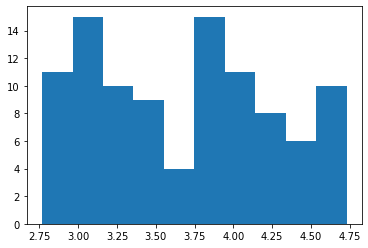

In [78]:
fig, ax = plt.subplots()
ax.hist(np.diff(a))

In [9]:
print(np.cumsum(a))

[ 4.32791013  8.15452726 10.77450163 14.21224306 18.54609139 21.35057355
 25.39716267 28.85362188 32.6130313  36.91854867 39.68912179 43.04538751]


In [73]:
print(len(a))
print(len(np.cumsum(a)))

240
240


In [5]:
print(a)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


### Practice file getting

In [2]:
dataFolder = r'C:\Users\lesliec\data\eeg_pilot\mouse505550\pilot1_2020-03-02_10-08-51\recording1'

In [10]:
print(sorted(glob(dataFolder + '/*.sync', recursive=True)))

['C:\\Users\\lesliec\\data\\eeg_pilot\\mouse505550\\pilot1_2020-03-02_10-08-51\\recording1\\mouse505550_pilot1_200302_100826.sync']


In [11]:
sync_file = sorted(glob(dataFolder + '/*.sync', recursive=True))[0]
print(sync_file)

C:\Users\lesliec\data\eeg_pilot\mouse505550\pilot1_2020-03-02_10-08-51\recording1\mouse505550_pilot1_200302_100826.sync


In [9]:
sslog_file = sorted(glob(dataFolder + '\*.log', recursive=True))[0]
print(sslog_file)

C:\Users\lesliec\data\eeg_pilot\mouse505550\pilot1_2020-03-02_10-08-51\recording1\mouse505550_pilot1.log
